## Assignment 1
### Name: Pasupulety Chethan Krishna Venkat
### Roll Number: 21CS30036

In [5]:
# import all the necessary libraries here
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt


(768, 9)
Train accuracy: 0.9322916666666666
Test accuracy: 0.7012987012987013


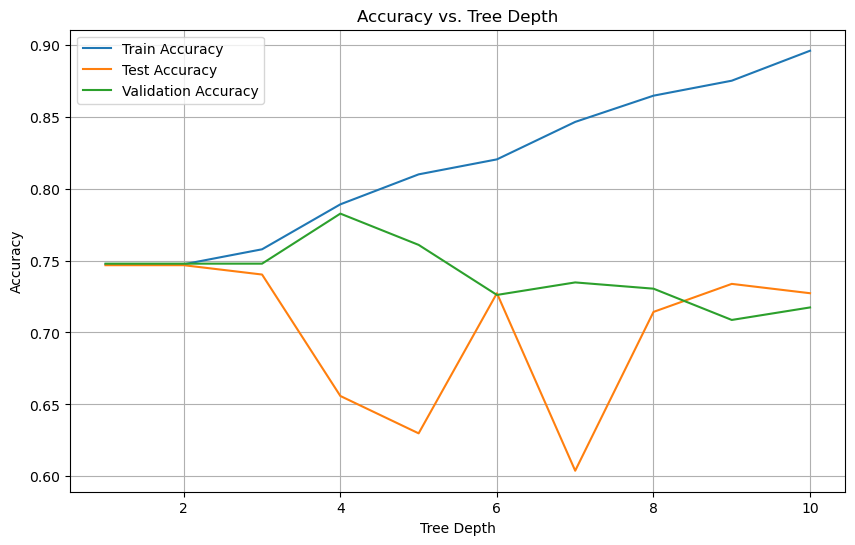

In [6]:
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape) 

# split the dataset into train and test and validation here
train_df, temp_data_df = train_test_split(df, test_size=0.5, random_state=42)
validation_df, test_df = train_test_split(temp_data_df, test_size=0.4, random_state=42)



# Convert DataFrame to numpy arrays
train_data = train_df.to_numpy()
test_data = test_df.to_numpy()
validation_data = validation_df.to_numpy()

# Split data into X and y
X_train = train_data[:, :-1]                     # all rows, all the features and no labels
y_train = train_data[:, -1]                      # all rows, label only


X_test = test_data[:, :-1]
y_test = test_data[:, -1]

X_validation = validation_data[:, :-1]
y_validation = validation_data[:, -1]


# a list to store the names of the features
feature_names = list(df.columns[:-1])



# Using the id3 algorithm to build the decision tree
# Since the data is continous,we need to find the best attribute to split the data and best threshold value for that attribute
# We will use the information gain to find the best attribute and threshold value
# We will use the entropy function to calculate the information gain

# Entropy function
def entropy(y):
    entropy = 0
    unique, counts = np.unique(y, return_counts=True)
    for i in range(len(unique)):
        entropy += -(counts[i]/len(y))*np.log2(counts[i]/len(y))
    return entropy

# Information gain function
def info_gain(X, y, attribute_index, threshold):
    entropy_before = entropy(y)
    entropy_after = 0
    y_left = []
    y_right = []
    for i in range(len(y)):
        if X[i][attribute_index] <= threshold:
            y_left.append(y[i])
        else:
            y_right.append(y[i])
    entropy_after = (len(y_left)/len(y))*entropy(y_left) + (len(y_right)/len(y))*entropy(y_right)
    return entropy_before - entropy_after


# Finding the best attribute and threshold value
def best_attribute_threshold(X, y):
    
    best_attribute_index = 0
    best_threshold = 0
    max_info_gain = 0
    for i in range(X.shape[1]):
        for j in range(X.shape[0]):
            info_gain_val = info_gain(X, y, i, X[j][i])
            if info_gain_val > max_info_gain:
                max_info_gain = info_gain_val
                best_attribute_index = i
                best_threshold = X[j][i]
    return (best_attribute_index, best_threshold)


# Node class for the decision tree
class Node:
    def __init__(self, attribute_index=None, threshold=None, left=None, right=None, label=None):
        self.attribute_index = attribute_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label
    
    def is_leaf_node(self):
        return self.label is not None


# Building the decision tree using the ID3 algorithm
# tree having  min_size as stopping criteria

def build_tree(X, y, min_size):
   
    if len(y) <= min_size:
        unique, counts = np.unique(y, return_counts=True)
        return Node(label=unique[np.argmax(counts)])
    best_attribute_index, best_threshold = best_attribute_threshold(X, y)
    y_left = []
    y_right = []
    X_left = []
    X_right = []
    for i in range(len(y)):
        if X[i][best_attribute_index] <= best_threshold:
            y_left.append(y[i])
            X_left.append(X[i])
        else:
            y_right.append(y[i])
            X_right.append(X[i])
    if len(y_left) == 0 or len(y_right) == 0:
        unique, counts = np.unique(y, return_counts=True)
        return Node(label=unique[np.argmax(counts)])
    left = build_tree(np.array(X_left), np.array(y_left), min_size)
    right = build_tree(np.array(X_right), np.array(y_right), min_size)
    return Node(best_attribute_index, best_threshold, left, right)






# Predicting the label for a single data point
def predict(node, data_point):
  
    if node.is_leaf_node():
        return node.label
    if data_point[node.attribute_index] <= node.threshold:
        return predict(node.left, data_point)
    else:
        return predict(node.right, data_point)


# Predicting the labels for a set of data points
def predict_labels(root, X):
    
    y_pred = []
    for i in range(len(X)):
        y_pred.append(predict(root, X[i]))
    return np.array(y_pred)


# Calculating the accuracy of the model
def accuracy(y_pred, y_true):
   
    correct = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            correct += 1
    return correct/len(y_pred)


# printing the tree with feature names and threshold value using graphviz and saving it as png
def visualize_tree(node, feature_names, graph=None):
    if graph is None:
        graph = Digraph(format='png')  # You can change the format if you prefer a different image format
    
    if node.is_leaf_node():
        graph.node(str(id(node)), label=str(node.label))
    else:
        feature_name = feature_names[node.attribute_index]
        graph.node(str(id(node)), label=f"{feature_name}\nThreshold {node.threshold}")
        if node.left:
            visualize_tree(node.left, feature_names, graph)
            graph.edge(str(id(node)), str(id(node.left)), label='True')
        if node.right:
            visualize_tree(node.right, feature_names, graph)
            graph.edge(str(id(node)), str(id(node.right)), label='False')
    
    return graph
  
# pruning with respect to the validation set and depth of the tree

def reduced_error_pruning(node, X_validation, y_validation):
    # Write your code to perform the reduced error pruning algorithm
    # Return the root node of the pruned decision tree
    # YOUR CODE HERE
    if node.is_leaf_node():
        return node
    if node.left.is_leaf_node() and node.right.is_leaf_node():
        y_pred = predict_labels(node, X_validation)
        accuracy_before = accuracy(y_pred, y_validation)

        # changing the nodes label to the most common label in the validation set
        unique, counts = np.unique(y_validation, return_counts=True)
        node.label = unique[np.argmax(counts)]
        

       
        y_pred = predict_labels(node, X_validation)
        accuracy_after = accuracy(y_pred, y_validation)
        if accuracy_after >= accuracy_before:
            node.left = None
            node.right = None
            return node
        else:
            node.label = None
            return node
    node.left = reduced_error_pruning(node.left, X_validation, y_validation)
    node.right = reduced_error_pruning(node.right, X_validation, y_validation)
    return node


# pruning with respect to the validation set and depth of the tree

# changing depth of the tree
def build_tree_depth(X, y, min_size, depth):
    if len(y) <= min_size:
        unique, counts = np.unique(y, return_counts=True)
        return Node(label=unique[np.argmax(counts)])
    best_attribute_index, best_threshold = best_attribute_threshold(X, y)
    y_left = []
    y_right = []
    X_left = []
    X_right = []
    for i in range(len(y)):
        if X[i][best_attribute_index] <= best_threshold:
            y_left.append(y[i])
            X_left.append(X[i])
        else:
            y_right.append(y[i])
            X_right.append(X[i])
    if len(y_left) == 0 or len(y_right) == 0:
        unique, counts = np.unique(y, return_counts=True)
        return Node(label=unique[np.argmax(counts)])
    if depth == 0:
        unique, counts = np.unique(y, return_counts=True)
        return Node(label=unique[np.argmax(counts)])
    left = build_tree_depth(np.array(X_left), np.array(y_left), min_size, depth-1)
    right = build_tree_depth(np.array(X_right), np.array(y_right), min_size, depth-1)
    return Node(best_attribute_index, best_threshold, left, right)


# plotting accuracy for  the graph for different depth values

def plot_accuracy(X_train, y_train, X_test, y_test, X_validation, y_validation):
    train_accuracy = []
    test_accuracy = []
    validation_accuracy = []
    for i in range(1, 11):
        root = build_tree_depth(X_train, y_train, 10, i)
        y_pred = predict_labels(root, X_train)
        train_accuracy.append(accuracy(y_pred, y_train))
        y_pred = predict_labels(root, X_test)
        test_accuracy.append(accuracy(y_pred, y_test))
        y_pred = predict_labels(root, X_validation)
        validation_accuracy.append(accuracy(y_pred, y_validation))
    return train_accuracy, test_accuracy, validation_accuracy

       
    







    

    


# Main function
def main():
    # Build the tree
    root = build_tree(X_train, y_train, 10)
    
   # Visualize the tree
    graph = visualize_tree(root, feature_names)
    graph.render('decision_tree', view=True)

    # Predict the labels for the test data
    y_pred = predict_labels(root, X_test)
    
    # Calculate the accuracy of the model on train and test data
    train_accuracy = accuracy(predict_labels(root, X_train), y_train)
    test_accuracy = accuracy(y_pred, y_test)

    print(f"Train accuracy: {train_accuracy}")
    print(f"Test accuracy: {test_accuracy}")


    # plot accuracy vs depth plots

    

    train_accuracy, test_accuracy, validation_accuracy = plot_accuracy(X_train, y_train, X_test, y_test, X_validation, y_validation)

    # Create a range of depths (assuming you have 10 depths)
    depths = list(range(1, 11))

    # Plot the accuracy values
    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_accuracy, label='Train Accuracy')
    plt.plot(depths, test_accuracy, label='Test Accuracy')
    plt.plot(depths, validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Tree Depth')
    plt.legend()
    plt.grid(True)
    plt.show()


    
    





  


    
if __name__ == '__main__':
    main()











In [ ]:



    

    


# Main function
def main():
    # Build the tree
    root = build_tree(X_train, y_train, 10)
    
   # Visualize the tree
    graph = visualize_tree(root, feature_names)
    graph.render('decision_tree', view=True)

    # Predict the labels for the test data
    y_pred = predict_labels(root, X_test)
    
    # Calculate the accuracy of the model on train and test data
    train_accuracy = accuracy(predict_labels(root, X_train), y_train)
    test_accuracy = accuracy(y_pred, y_test)

    print(f"Train accuracy: {train_accuracy}")
    print(f"Test accuracy: {test_accuracy}")


    # plot accuracy vs depth plots

    

    train_accuracy, test_accuracy, validation_accuracy = plot_accuracy(X_train, y_train, X_test, y_test, X_validation, y_validation)

    # Create a range of depths (assuming you have 10 depths)
    depths = list(range(1, 11))

    # Plot the accuracy values
    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_accuracy, label='Train Accuracy')
    plt.plot(depths, test_accuracy, label='Test Accuracy')
    plt.plot(depths, validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Tree Depth')
    plt.legend()
    plt.grid(True)
    plt.show()


    
    





  


    
if __name__ == '__main__':
    main()









